In [2]:
import pandas as pd
import numpy as np
import xarray as xr
import geopandas as gpd
from glob import glob

import matplotlib.pyplot as plt

import rioxarray as rio
from shapely.geometry import mapping

%matplotlib inline
# %matplotlib widget

In [3]:
# #### README: to change the region od Interest 
# (1) print hma.Names or hma.Names[ind-of-interest]
# (2) choose the name of a region of interest 
# (3) clip netcdf with the region of interest 

## Locations of the median points for precipitation 

### hma regions

In [14]:
hma = gpd.read_file('HMA_regions/HMA_regions.shp')
# hma.plot()

# as dataframe
hma_df = pd.DataFrame(hma) 
# hma_df.columns
# hma_df.Name[4]

## era5

In [15]:
climate = xr.open_mfdataset('*.nc', decode_coords="all")
# cnange units (and overwrite the metadata with the units after)

#convert temperature K to C
climate['t2m']=climate.t2m-273.15
# precipotation m to mm 
climate['tp']=climate.tp * 1000
# radiation j/m2 to w/m2
# SSR [W/m2] = SSR [J/m^2] / (3600 seconds)
climate['ssrd'] = climate.ssrd / 3600


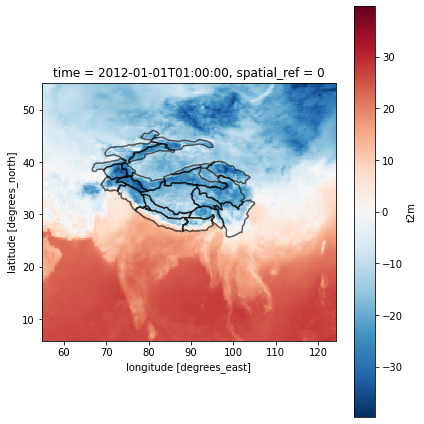

In [22]:
# plot all regions and climate data

fig, ax = plt.subplots(figsize=(6, 6))
climate.t2m[1,:,:].plot()#palette='viridis')
hma.boundary.plot(ax=ax, alpha=.6, color='black')
fig.tight_layout()




In [24]:
''' change name of the mountain range here'''

# roi = hma[hma['Name'] == 'Central Himalaya']
roi = hma[hma['Name'] == hma_df.Name[3]]
name = roi.Name
print(roi.Name)
# karakoram.crs

# add crs to the dataset (netcdf file) - maybe this is not even needed 
climate = climate.rio.write_crs('EPSG:4326')

# clip using xarrayrio library:
roi_climate = climate.rio.clip(roi.geometry, roi.crs, drop=True, invert=False)

3    Central Himalaya
Name: Name, dtype: object


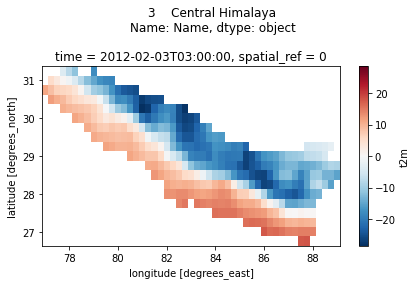

In [25]:
# see how it looks like

roi_climate.t2m[795,:,:].plot()
plt.suptitle(str(name))
plt.tight_layout()

## median locations of temp2012 and annual sum of precipitation 

In [47]:
locations_tp   = pd.read_csv('out/median_annual_precip_regions.csv').drop('Unnamed: 0', axis =1).set_index('Name')
locations_temp = pd.read_csv('out/median_temp_regions_2012.csv').set_index('Name')


locations_temp.index

Index(['Eastern Hindu Kush', 'Weatern Himalaya', 'Eastern Himalaya',
       'Central Himalaya', 'Karakoram', 'Western Pamir', 'Pamir Alay',
       'Northern/Western Tien Shan', 'Dzhungarsky Alatau',
       'Western Kunlun Shan', 'Nyainqentanglha', 'Gangdise Mountains',
       'Hengduan Shan', 'Tibetan Interior Mountains', 'Tanggula Shan',
       'Eastern Tibetan Mountains', 'Qilian Shan', 'Eastern Kunlun Shan',
       'Altun Shan', 'Eastern Tien Shan', 'Central Tien Shan',
       'Eastern Pamir'],
      dtype='object', name='Name')

### Precipitation loc


In [144]:
locations_tp.loc['3 Central Himalaya'] 

# 27.5 84.5

lat_tp = 27.500000
lon_tp = 84.500000

### Temperature loc locations_tp.loc['3 Central Himalaya']

In [145]:
locations_temp.loc['Central Himalaya']

# 31.25 78.0
lat_temp = 31.25000
lon_temp = 78.00000

In [146]:
## convert to dataframe
roi_climate_df = roi_climate.to_dataframe() 
roi_climate_df = roi_climate_df.reset_index()

roi_climate_df = roi_climate_df.dropna()
roi_climate_df = roi_climate_df.drop_duplicates()


In [147]:
roi_climate_df.head()

,latitude,longitude,time,spatial_ref,ssrd,t2m,tcc,tp
26352,31.25,77.75,2012-01-01 00:00:00,0,0.000000,1.000153,0.176659,0.000004
26353,31.25,77.75,2012-01-01 01:00:00,0,0.000000,1.164093,0.239589,0.000004
26354,31.25,77.75,2012-01-01 02:00:00,0,0.757569,0.964569,0.142920,0.000004
26355,31.25,77.75,2012-01-01 03:00:00,0,88.279900,1.790497,0.088108,0.000004
26356,31.25,77.75,2012-01-01 04:00:00,0,261.329132,3.238190,0.104405,0.001065


### how many era5 pixels there are? 

In [148]:
# calculate how many era5 pix fall into the mountain range polygon

x = roi_climate.t2m[1,:,:].values.flatten()
print('total numnber of pixels within bbox:', x.shape, '\n')

# without nans
x2 = x[~np.isnan(x)]
print('number of not-nan pixels:', x2.shape)

total numnber of pixels within bbox: (931,) 

number of not-nan pixels: (376,)


### plot ALL time-series of ALL pixels within region roi_climate_df

In [149]:
# roi_climate_df.columns
# roi_climate_df.head()

In [150]:
# (1) sub-select temperatures and precipitation separately: 
t2m = roi_climate_df[['latitude', 'longitude', 'time', 't2m']]
tp = roi_climate_df[['latitude', 'longitude', 'time', 'tp']]
tcc = roi_climate_df[['latitude', 'longitude', 'time', 'tcc']]
ssrd = roi_climate_df[['latitude', 'longitude', 'time', 'ssrd']]




In [151]:
lats_and_lons = roi_climate_df[['latitude', 'longitude']].groupby(['latitude', 'longitude']).size().reset_index()
print('how many unique pairs of coordinates there are:', len(lats_and_lons))

how many unique pairs of coordinates there are: 376


## just all grid cells 

CPU times: user 5.29 s, sys: 419 ms, total: 5.71 s
Wall time: 2.62 s


Text(0.5, 0.98, '3    Central Himalaya\nName: Name, dtype: object')

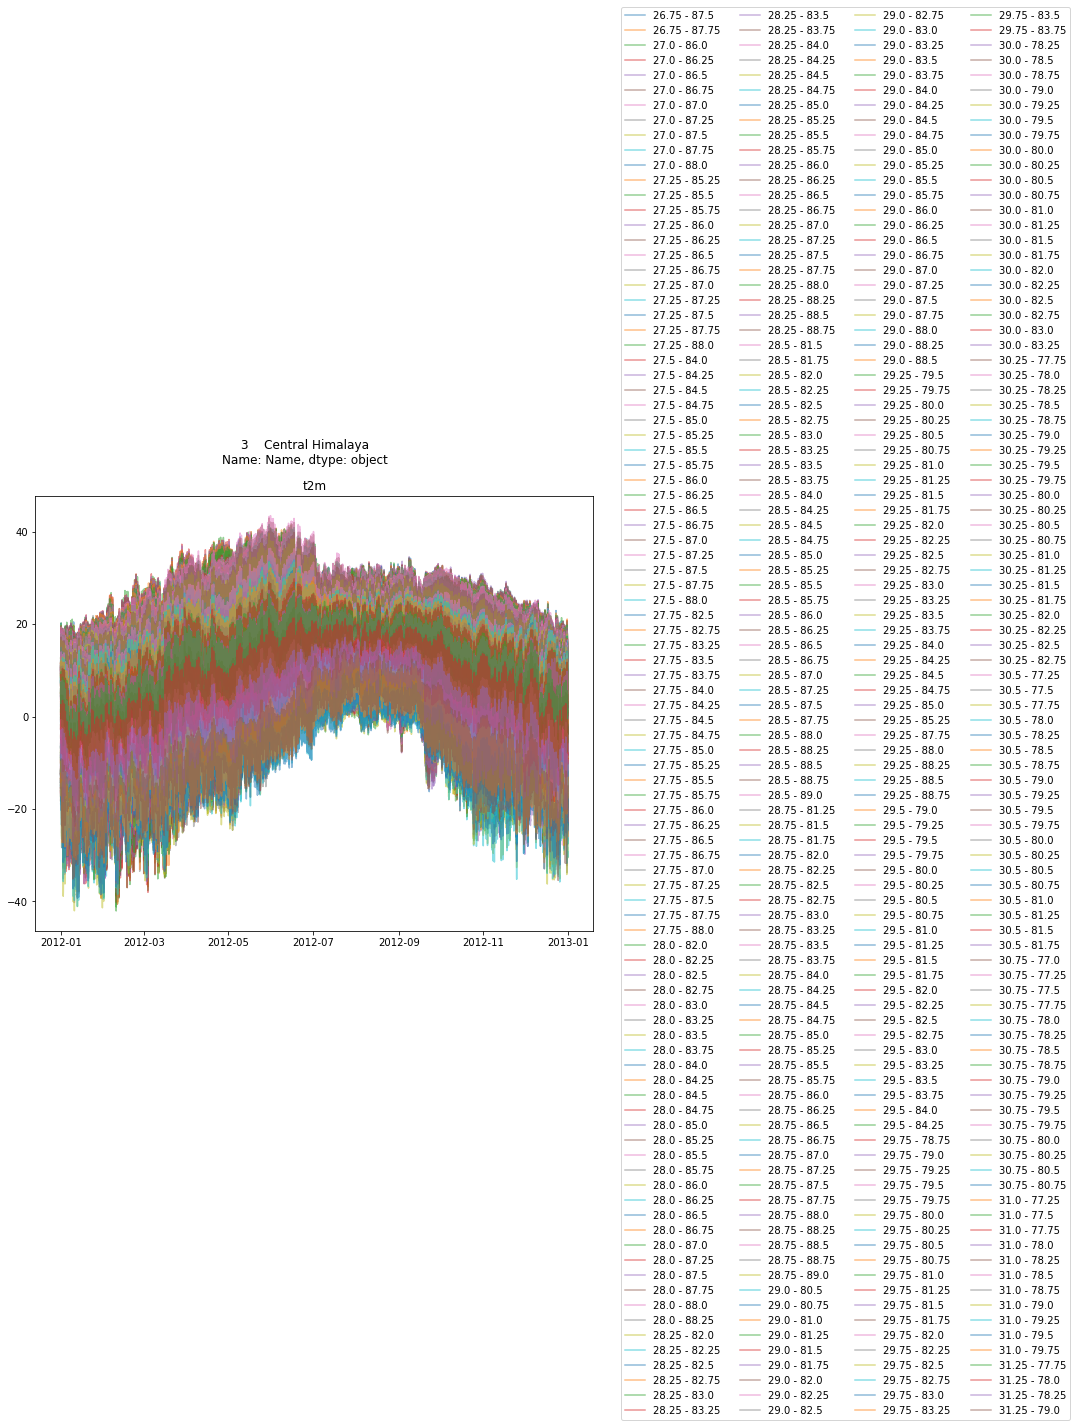

In [152]:
%%time
#  TEMPERATURES: 

fig, ax = plt.subplots(figsize=(10, 8))

# short = roi.reset_index()

subs_t2m = []

# for lat, lon in zip(roi.latitude, roi.longitude):

for lat, lon in zip(lats_and_lons.latitude, lats_and_lons.longitude):

# for lat, lon in zip(short.latitude.unique(), short.longitude.unique()):
    # print(lat, lon)
    subdf = t2m[(t2m.latitude==lat) & (t2m.longitude==lon)]
    subdf.set_index('time', inplace=True)
    
    subs_t2m.append(subdf)
    
    ax.plot(subdf.index, subdf.t2m, alpha = 0.5, label='{lat} - {lon}'.format(lat=lat, lon=lon))
ax.legend(bbox_to_anchor=(1.04,0.5), loc="center left", ncol=4)
plt.title('t2m')
plt.suptitle(str(name))



## all grid cells with the median annual precip and temp 

CPU times: user 5.38 s, sys: 382 ms, total: 5.76 s
Wall time: 2.16 s


Text(0.5, 0.98, '3    Central Himalaya\nName: Name, dtype: object')

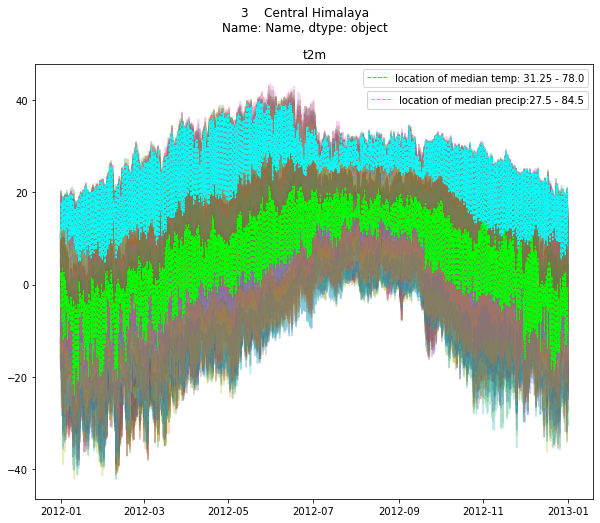

In [158]:
%%time
#  TEMPERATURES: 

fig, ax = plt.subplots(figsize=(10, 8))

# short = roi.reset_index()

subs_t2m = []

# for lat, lon in zip(roi.latitude, roi.longitude):

for lat, lon in zip(lats_and_lons.latitude, lats_and_lons.longitude):

# for lat, lon in zip(short.latitude.unique(), short.longitude.unique()):
    # print(lat, lon)
    subdf = t2m[(t2m.latitude==lat) & (t2m.longitude==lon)]
    subdf.set_index('time', inplace=True)
    
    subs_t2m.append(subdf)
    
    ax.plot(subdf.index, subdf.t2m, alpha = 0.3, label='{lat} - {lon}'.format(lat=lat, lon=lon))
# ax.legend(bbox_to_anchor=(1.04,0.5), loc="center left", ncol=4)
# plt.title('t2m')
# plt.suptitle(str(name))




##### ---- add median point with manually specified coordinates --------


# -- total median annual precipitation ------
mediandf_tp = t2m[(t2m.latitude==lat_tp) & (t2m.longitude==lon_tp)]
mediandf_tp = mediandf_tp.set_index('time')#, inplace=True)

precip = ax.plot(mediandf_tp.index, mediandf_tp.t2m, alpha = 1, 
                 label='location of median precip: {lat} - {lon}'.format(lat=lat_tp, lon=lon_tp), 
                 linestyle = 'dashed', linewidth = 1, color = 'cyan')

# --- median temperature ------- 
mediandf_temp = t2m[(t2m.latitude==lat_temp) & (t2m.longitude==lon_temp)]
mediandf_temp = mediandf_temp.set_index('time')

temp = ax.plot(mediandf_temp.index, mediandf_temp.t2m, alpha = 1, 
               label='location of median temp: {lat} - {lon}'.format(lat = lat_temp, lon = lon_temp),
               linestyle = 'dashed', linewidth = 1, color = 'lime')


# --- legends
temp_legend = plt.legend(handles=temp, bbox_to_anchor=(1,1))#, label = 'location of median temp') 
precip_legend = plt.legend(handles=precip, bbox_to_anchor=(1,0.95))#, label = 'location of median precip')

# --- add the legends
ax = plt.gca().add_artist(temp_legend)
ax = plt.gca().add_artist(precip_legend)


plt.title('t2m')
plt.suptitle(str(name))

## Precipitation

## just all grid cells 

CPU times: user 6.58 s, sys: 414 ms, total: 7 s
Wall time: 3.57 s


Text(0.5, 0.98, '3    Central Himalaya\nName: Name, dtype: object')

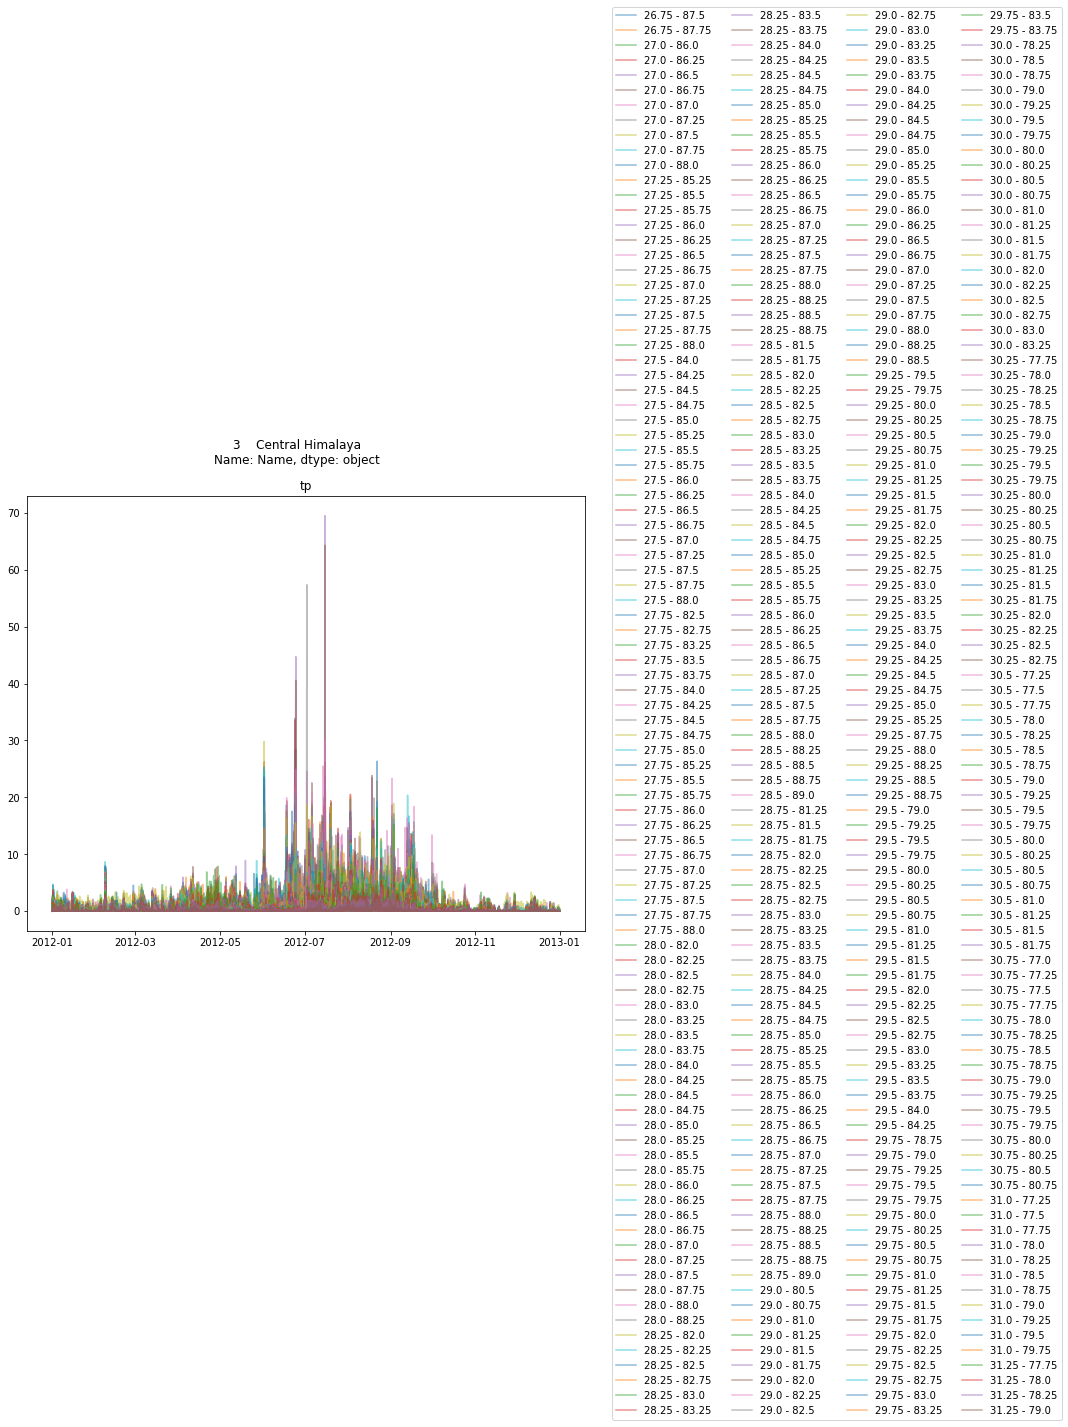

In [155]:
%%time
# TOTAL PRECIPITATION (HOURLY)

sub_tp = []

fig, ax = plt.subplots(figsize=(10, 8))

for lat, lon in zip(lats_and_lons.latitude, lats_and_lons.longitude):
    subdf = tp[(tp.latitude==lat) & (tp.longitude==lon)]
    subdf.set_index('time', inplace=True)
    
    sub_tp.append(subdf)
    
    ax.plot(subdf.index, subdf.tp, alpha = 0.5, label='{lat} - {lon}'.format(lat=lat, lon=lon))
ax.legend(bbox_to_anchor=(1.04,0.5), loc="center left", ncol=4)
plt.title('tp')
plt.suptitle(str(name))





## all grid cells with the median annual precip and temp 

CPU times: user 6.62 s, sys: 537 ms, total: 7.16 s
Wall time: 4.03 s


Text(0.5, 0.98, '3    Central Himalaya\nName: Name, dtype: object')

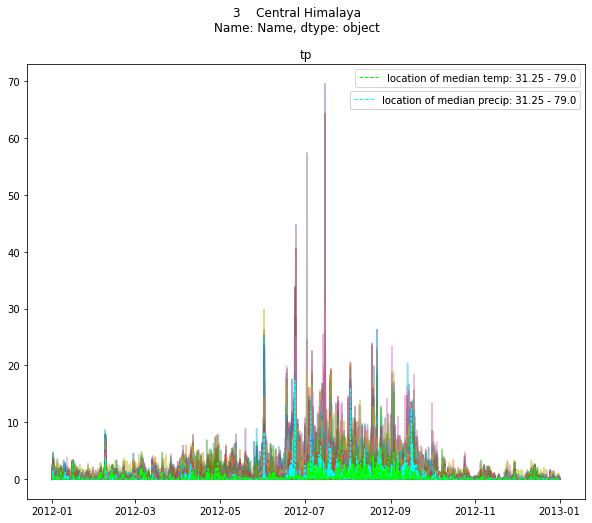

In [156]:
%%time
# TOTAL PRECIPITATION (HOURLY)

sub_tp = []

fig, ax = plt.subplots(figsize=(10, 8))

for lat, lon in zip(lats_and_lons.latitude, lats_and_lons.longitude):
    subdf = tp[(tp.latitude==lat) & (tp.longitude==lon)]
    subdf.set_index('time', inplace=True)
    
    sub_tp.append(subdf)
    
    ax.plot(subdf.index, subdf.tp, alpha = 0.5, label='{lat} - {lon}'.format(lat=lat, lon=lon))
ax.legend(bbox_to_anchor=(1.04,0.5), loc="center left", ncol=4)
plt.title('tp')
plt.suptitle(str(name))



##### ---- add median point with manually specified coordinates --------


# -- total median annual precipitation ------
mediandf_tp = tp[(tp.latitude==lat_tp) & (tp.longitude==lon_tp)]
mediandf_tp = mediandf_tp.set_index('time')#, inplace=True)

precip = ax.plot(mediandf_tp.index, mediandf_tp.tp, alpha = 1,
                 label='location of median precip: {lat} = {lon}'.format(lat=lat_tp, lon=lon_tp)', 
                 linestyle = 'dashed', linewidth = 1, color = 'cyan')

# --- median temperature ------- 
mediandf_temp = tp[(tp.latitude==lat_temp) & (tp.longitude==lon_temp)]
mediandf_temp = mediandf_temp.set_index('time')

temp = ax.plot(mediandf_temp.index, mediandf_temp.tp, alpha = 1, 
               label='location of median temp: {lat} - {lon}'.format(lat=lat_temp, lon=lon_temp), 
               linestyle = 'dashed', linewidth = 1, color = 'lime')


# --- legends
temp_legend = plt.legend(handles=temp, bbox_to_anchor=(1,1)) #bbox_to_anchor=(0.325,0.95))
precip_legend = plt.legend(handles=precip, bbox_to_anchor=(1,0.95))#bbox_to_anchor=(0.325,1))


# --- add the legends
ax = plt.gca().add_artist(temp_legend)
ax = plt.gca().add_artist(precip_legend)


plt.title('tp')
plt.suptitle(str(name))